In [352]:
import argparse
import os
import pathlib
import sys
import numpy as np
import torch
import imageio
import util
import bayes3d as b
from tqdm import tqdm

import nvdiffrast.torch as dr

#----------------------------------------------------------------------------
# Quaternion math.
#----------------------------------------------------------------------------

# Unit quaternion.
def q_unit():
    return np.asarray([1, 0, 0, 0], np.float32)

# Get a random normalized quaternion.
def q_rnd():
    u, v, w = np.random.uniform(0.0, 1.0, size=[3])
    v *= 2.0 * np.pi
    w *= 2.0 * np.pi
    return np.asarray([(1.0-u)**0.5 * np.sin(v), (1.0-u)**0.5 * np.cos(v), u**0.5 * np.sin(w), u**0.5 * np.cos(w)], np.float32)

# Get a random quaternion from the octahedral symmetric group S_4.
_r2 = 0.5**0.5
_q_S4 = [[ 1.0, 0.0, 0.0, 0.0], [ 0.0, 1.0, 0.0, 0.0], [ 0.0, 0.0, 1.0, 0.0], [ 0.0, 0.0, 0.0, 1.0],
         [-0.5, 0.5, 0.5, 0.5], [-0.5,-0.5,-0.5, 0.5], [ 0.5,-0.5, 0.5, 0.5], [ 0.5, 0.5,-0.5, 0.5],
         [ 0.5, 0.5, 0.5, 0.5], [-0.5, 0.5,-0.5, 0.5], [ 0.5,-0.5,-0.5, 0.5], [-0.5,-0.5, 0.5, 0.5],
         [ _r2,-_r2, 0.0, 0.0], [ _r2, _r2, 0.0, 0.0], [ 0.0, 0.0, _r2, _r2], [ 0.0, 0.0,-_r2, _r2],
         [ 0.0, _r2, _r2, 0.0], [ _r2, 0.0, 0.0,-_r2], [ _r2, 0.0, 0.0, _r2], [ 0.0,-_r2, _r2, 0.0],
         [ _r2, 0.0, _r2, 0.0], [ 0.0, _r2, 0.0, _r2], [ _r2, 0.0,-_r2, 0.0], [ 0.0,-_r2, 0.0, _r2]]
def q_rnd_S4():
    return np.asarray(_q_S4[np.random.randint(24)], np.float32)

# Quaternion slerp.
def q_slerp(p, q, t):
    d = np.dot(p, q)
    if d < 0.0:
        q = -q
        d = -d
    if d > 0.999:
        a = p + t * (q-p)
        return a / np.linalg.norm(a)
    t0 = np.arccos(d)
    tt = t0 * t
    st = np.sin(tt)
    st0 = np.sin(t0)
    s1 = st / st0
    s0 = np.cos(tt) - d*s1
    return s0*p + s1*q

# Quaterion scale (slerp vs. identity quaternion).
def q_scale(q, scl):
    return q_slerp(q_unit(), q, scl)

# Quaternion product.
def q_mul(p, q):
    s1, V1 = p[0], p[1:]
    s2, V2 = q[0], q[1:]
    s = s1*s2 - np.dot(V1, V2)
    V = s1*V2 + s2*V1 + np.cross(V1, V2)
    return np.asarray([s, V[0], V[1], V[2]], np.float32)

# Angular difference between two quaternions in degrees.
def q_angle_deg(p, q):
    p = p.detach().cpu().numpy()
    q = q.detach().cpu().numpy()
    d = np.abs(np.dot(p, q))
    d = min(d, 1.0)
    return np.degrees(2.0 * np.arccos(d))

# Quaternion product
def q_mul_torch(p, q):
    a = p[0]*q[0] - p[1]*q[1] - p[2]*q[2] - p[3]*q[3]
    b = p[0]*q[1] + p[1]*q[0] + p[2]*q[3] - p[3]*q[2]
    c = p[0]*q[2] + p[2]*q[0] + p[3]*q[1] - p[1]*q[3]
    d = p[0]*q[3] + p[3]*q[0] + p[1]*q[2] - p[2]*q[1]
    return torch.stack([a, b, c, d])

# Convert quaternion to 4x4 rotation matrix.
def q_to_mtx(q):
    r0 = torch.stack([1.0-2.0*q[1]**2 - 2.0*q[2]**2, 2.0*q[0]*q[1] - 2.0*q[2]*q[3], 2.0*q[0]*q[2] + 2.0*q[1]*q[3]])
    r1 = torch.stack([2.0*q[0]*q[1] + 2.0*q[2]*q[3], 1.0 - 2.0*q[0]**2 - 2.0*q[2]**2, 2.0*q[1]*q[2] - 2.0*q[0]*q[3]])
    r2 = torch.stack([2.0*q[0]*q[2] - 2.0*q[1]*q[3], 2.0*q[1]*q[2] + 2.0*q[0]*q[3], 1.0 - 2.0*q[0]**2 - 2.0*q[1]**2])
    rr = torch.transpose(torch.stack([r0, r1, r2]), 1, 0)
    rr = torch.cat([rr, torch.tensor([[0], [0], [0]], dtype=torch.float32).cuda()], dim=1) # Pad right column.
    rr = torch.cat([rr, torch.tensor([[0, 0, 0, 1]], dtype=torch.float32).cuda()], dim=0)  # Pad bottom row.
    return rr

# Transform vertex positions to clip space
def transform_pos(mtx, pos):
    t_mtx = torch.from_numpy(mtx).cuda() if isinstance(mtx, np.ndarray) else mtx
    # (x,y,z) -> (x,y,z,1)
    posw = torch.cat([pos, torch.ones([pos.shape[0], 1]).cuda()], axis=1)
    return torch.matmul(posw, t_mtx.t())[None, ...]

def render(glctx, mtx, pos, pos_idx, col, col_idx, resolution: int):
    # Setup TF graph for reference.
    pos_clip    = transform_pos(mtx, pos)
    rast_out, _ = dr.rasterize(glctx, pos_clip, pos_idx, resolution=[resolution, resolution])
    color   , _ = dr.interpolate(col[None, ...], rast_out, col_idx)
    color       = dr.antialias(color, rast_out, pos_clip, pos_idx)
    # return color
    return rast_out[:,:,:,2:3]


In [353]:
datadir = "/home/nishadgothoskar/nvdiffrast/samples/data/"
with np.load(f'{datadir}/cube_p.npz') as f:
    pos_idx, pos, col_idx, col = f.values()
print("Mesh has %d triangles and %d vertices." % (pos_idx.shape[0], pos.shape[0]))

# Some input geometry contains vertex positions in (N, 4) (with v[:,3]==1).  Drop
# the last column in that case.
if pos.shape[1] == 4: pos = pos[:, 0:3]

# Create position/triangle index tensors
pos_idx = torch.from_numpy(pos_idx.astype(np.int32)).cuda()
vtx_pos = torch.from_numpy(pos.astype(np.float32)).cuda()
col_idx = torch.from_numpy(col_idx.astype(np.int32)).cuda()
vtx_col = torch.from_numpy(col.astype(np.float32)).cuda()
print(pos_idx.shape, vtx_pos.shape, col_idx.shape, vtx_col.shape)
print(vtx_col)

Mesh has 12 triangles and 24 vertices.
torch.Size([12, 3]) torch.Size([24, 3]) torch.Size([12, 3]) torch.Size([6, 3])
tensor([[1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 1.0000],
        [0.0000, 1.0000, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [1.0000, 0.6470, 0.0000]], device='cuda:0')


In [354]:
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
idx = 14
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
m = b.utils.load_mesh(mesh_path)
m = b.utils.scale_mesh(m, 1.0/100.0)

In [355]:
vtx_pos = torch.from_numpy(m.vertices.astype(np.float32)).cuda()
pos_idx = torch.from_numpy(m.faces.astype(np.int32)).cuda()
col_idx = torch.from_numpy(np.zeros((vtx_pos.shape[0],3)).astype(np.int32)).cuda()
vtx_col = torch.from_numpy(np.ones((1,3)).astype(np.float32)).cuda()

In [356]:
vtx_pos.max(0)

torch.return_types.max(
values=tensor([0.5848, 0.4654, 0.4069], device='cuda:0'),
indices=tensor([3989, 6774, 7216], device='cuda:0'))

In [357]:
max_iter           = 10000
repeats            = 1
log_interval       = 10
display_interval   = None
display_res        = 512
lr_base            = 0.01
lr_falloff         = 1.0
nr_base            = 1.0
nr_falloff         = 1e-4
grad_phase_start   = 0.5
resolution         = 256
out_dir            = None
log_fn             = None
mp4save_interval   = None
mp4save_fn         = None
use_opengl         = False

In [350]:
glctx = dr.RasterizeGLContext() #if use_opengl else dr.RasterizeCudaContext()


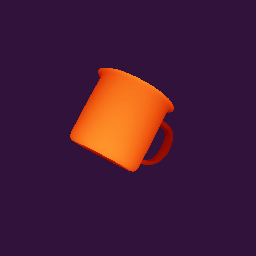

In [359]:
pose_target = torch.tensor(q_rnd(), device='cuda')

pose_init   = pose_target.cpu().numpy() + 0.3
pose_opt    = torch.tensor(pose_init / np.sum(pose_init**2)**0.5, dtype=torch.float32, device='cuda', requires_grad=True)

loss_best   = np.inf
pose_best   = pose_opt.detach().clone()

mvp = torch.tensor(np.matmul(util.projection(x=0.4), util.translate(0, 0, -3.5)).astype(np.float32), device='cuda')

rast_out = render(glctx, torch.matmul(mvp, q_to_mtx(pose_target)), vtx_pos, pos_idx, vtx_col, col_idx, resolution)

img_ref  = rast_out[0].detach().cpu().numpy()

# b.hstack_images([
#     b.get_rgb_image(img_ref[:,:]* 255.0) ,
# ])

b.hstack_images([
    b.get_depth_image(img_ref[:,:,0])
])

In [360]:
optimizer = torch.optim.Adam([pose_opt], betas=(0.9, 0.999), lr=lr_base)

In [361]:
images = []

In [362]:
for _ in tqdm(range(200)):
    noise = q_unit()
    color          = render(glctx, torch.matmul(mvp, q_to_mtx(pose_target)), vtx_pos, pos_idx, vtx_col, col_idx, resolution)
    pose_total_opt = q_mul_torch(pose_opt, noise)
    mtx_total_opt  = torch.matmul(mvp, q_to_mtx(pose_total_opt))
    color_opt      = render(glctx, mtx_total_opt, vtx_pos, pos_idx, vtx_col, col_idx, resolution)
    
    diff = (color_opt - color)**2 # L2 norm.
    diff = torch.tanh(5.0 * torch.max(diff, dim=-1)[0])
    loss = torch.mean(diff)
    loss_val = float(loss)
    if (loss_val < loss_best) and (loss_val > 0.0):
        pose_best = pose_total_opt.detach().clone()
        loss_best = loss_val
                
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(pose_opt.grad)
    
    with torch.no_grad():
        pose_opt /= torch.sum(pose_opt**2)**0.5
    
    img_ref  = color[0].detach().cpu().numpy()
    img_opt  = color_opt[0].detach().cpu().numpy()
    img_best = render(glctx, torch.matmul(mvp, q_to_mtx(pose_best)), vtx_pos, pos_idx, vtx_col, col_idx, resolution)[0].detach().cpu().numpy()
    
    # images.append(b.hstack_images([
    #     b.get_rgb_image(img_ref * 255.0),
    #     b.get_rgb_image(img_best * 255.0),
    # ]))
    images.append(b.hstack_images([
        b.get_depth_image(img_ref[:,:,0]),
        b.get_depth_image(img_best[:,:,0]),
    ]))

  7%|█████████▋                                                                                                                                | 14/200 [00:00<00:02, 66.50it/s]

tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')


 14%|███████████████████▎                                                                                                                      | 28/200 [00:00<00:02, 66.74it/s]

tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')


 18%|████████████████████████▏                                                                                                                 | 35/200 [00:00<00:02, 65.58it/s]

tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')


 28%|██████████████████████████████████████▋                                                                                                   | 56/200 [00:00<00:02, 67.66it/s]

tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')


 35%|████████████████████████████████████████████████▎                                                                                         | 70/200 [00:01<00:01, 67.47it/s]

tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')


 38%|█████████████████████████████████████████████████████▏                                                                                    | 77/200 [00:01<00:01, 66.69it/s]

tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')


 49%|███████████████████████████████████████████████████████████████████▌                                                                      | 98/200 [00:01<00:01, 66.69it/s]

tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')


 52%|███████████████████████████████████████████████████████████████████████▉                                                                 | 105/200 [00:01<00:01, 66.62it/s]

tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')


 63%|██████████████████████████████████████████████████████████████████████████████████████▎                                                  | 126/200 [00:01<00:01, 66.96it/s]

tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')


 70%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 140/200 [00:02<00:00, 66.86it/s]

tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 154/200 [00:02<00:00, 67.14it/s]

tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 161/200 [00:02<00:00, 67.09it/s]

tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 175/200 [00:02<00:00, 65.91it/s]

tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 189/200 [00:02<00:00, 65.79it/s]

tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 66.57it/s]

tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0.], device='cuda:0')


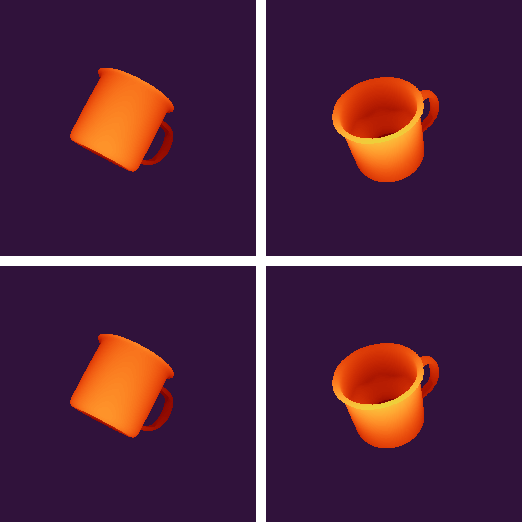

In [363]:
b.vstack_images([images[0],images[-1]])

RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.

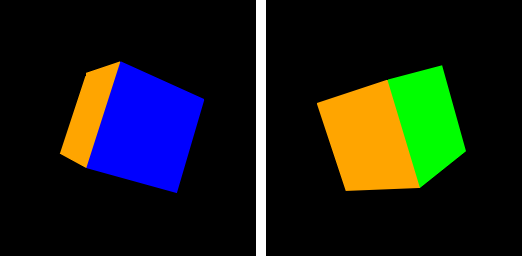